# **Detection Of Phishing Sites Project**
**Based on the paper: "Datasets for Phishing Websites Detection" (2020)**

Meir Gamla ID 311486781

## Data Source & Metadata

This project utilizes the **"Datasets for phishing websites detection"** dataset.

### Dataset Details

* **Dataset Name:** Datasets for phishing websites detection
* **Authors:** Grega Vrbančič, Iztok Fister Jr., Vili Podgorelec
* **Affiliation:** University of Maribor, Faculty of Electrical Engineering and Computer Science, Slovenia
* **Publication:** Data in Brief (Elsevier), Volume 33, 2020
* **DOI:** [10.1016/j.dib.2020.106438](https://doi.org/10.1016/j.dib.2020.106438)
* **Data Repository:** Mendeley Data (ID: 10.17632/72ptz43s9v.1)

### License

* **License:** CC BY-NC-ND 4.0 (Creative Commons Attribution-NonCommercial-NoDerivatives)


### **Important Note**:

The **original URLs** tested are not provided. Instead, there is a **ready-made simple feature table**. The details of the features will be provided below.


# Setup and Imports

In [ ]:
from google.colab import drive
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import pickle
import itertools
import joblib
import time
import shap
from datetime import datetime
from sklearn.base import clone
from sklearn.metrics import average_precision_score


# Check if running in Colab
if 'google.colab' in sys.modules:
    if not os.path.exists('phishing_project'):
        !git clone https://github.com/meir523/phishing_project.git
        !cd phishing_project && git lfs pull

    project_dir = '/content/phishing_project'

else:
    # Local execution
    project_dir = '.'

data_path = os.path.join(project_dir, 'data/dataset_full.csv')
src_dir = os.path.join(project_dir, 'src')
models_dir = os.path.join(project_dir, 'models')
models_noext_dir = os.path.join(models_dir, 'no_external')
print(f"Working directory set to: {project_dir}")

# Add project root to Python path
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# Clear import caches to see newly uploaded/synced files
importlib.invalidate_caches()

# Import local modules
import data_io, eda, preprocess, models, eval_utils, tuning, explain_utils
importlib.reload(data_io)
importlib.reload(eda)
importlib.reload(preprocess)
importlib.reload(models)
importlib.reload(eval_utils)
importlib.reload(tuning)
importlib.reload(explain_utils)

# Constants
RANDOM_STATE = 42
TARGET_COL = "phishing"
trainRatio = 0.7
valRatio = 0.15
testRatio = 0.15

Cloning into 'phishing_project'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 30 (delta 0), reused 30 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 35.60 MiB | 22.41 MiB/s, done.
Working directory set to: /content/phishing_project


# Data Preparation

### Data Loading, Initial EDA, Deduplication, and Train/Test Split

In [ ]:
# Load
df = data_io.load_dataset(data_path)

# First Impression
print("=== First Impression ===")
display(df.head(5))

# Basic report
rep_before = data_io.basic_report(df, target_col=TARGET_COL)
print("\n=== Raw Dataset (Before Dedup) ===")
print(f"Shape: {rep_before['shape']}")
print(f"#Features: {rep_before['n_features']}")
print(f"Target counts: {rep_before['target_counts']}")
print(f"Target ratio: {rep_before['target_ratio']}")
print(f"Duplicates (rows): {rep_before['n_duplicates']}")
print(f"Missing values (total): {rep_before['n_missing_total']}")

# Deduplicate
df, removed = data_io.drop_duplicates(df)
rep_after = data_io.basic_report(df, target_col=TARGET_COL)
print("\n=== After Dedup ===")
print(f"Removed duplicates: {removed}")
print(f"Shape: {rep_after['shape']}")
print(f"Target ratio: {rep_after['target_ratio']}")

# Split Train/Val/Test (70/15/15)
X_train, X_val, X_test, y_train, y_val, y_test = data_io.split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio = trainRatio,
    val_ratio = valRatio,
    test_ratio = testRatio,
    random_state=RANDOM_STATE
)

print("\n=== Train/Val/Test Split ===")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train target ratio: {(y_train.value_counts(normalize=True).round(4)).to_dict()}")
print(f"Val   target ratio: {(y_val.value_counts(normalize=True).round(4)).to_dict()}")
print(f"Test  target ratio: {(y_test.value_counts(normalize=True).round(4)).to_dict()}")


=== First Impression ===


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0



=== Raw Dataset (Before Dedup) ===
Shape: (88647, 112)
#Features: 111
Target counts: {0: 58000, 1: 30647}
Target ratio: {0: 0.65428, 1: 0.34572}
Duplicates (rows): 1438
Missing values (total): 0

=== After Dedup ===
Removed duplicates: 1438
Shape: (87209, 112)
Target ratio: {0: 0.6503, 1: 0.3497}

=== Train/Val/Test Split ===
Train: (61046, 111), Val: (13081, 111), Test: (13082, 111)
Train target ratio: {0: 0.6503, 1: 0.3497}
Val   target ratio: {0: 0.6503, 1: 0.3497}
Test  target ratio: {0: 0.6503, 1: 0.3497}


### 1. URL-Based Attributes
| Feature Name | Description |
| :--- | :--- |
| `qty_dot_url` | count (.) in URL |
| `qty_hyphen_url` | count (-) in URL |
| `qty_underline_url` | count (_) in URL |
| `qty_slash_url` | count (/) in URL |
| `qty_questionmark_url` | count (?) in URL |
| `qty_equal_url` | count (=) in URL |
| `qty_at_url` | count (@) in URL |
| `qty_and_url` | count (&) in URL |
| `qty_exclamation_url` | count (!) in URL |
| `qty_space_url` | count ( ) in URL |
| `qty_tilde_url` | count (~) in URL |
| `qty_comma_url` | count (,) in URL |
| `qty_plus_url` | count (+) in URL |
| `qty_asterisk_url` | count (*) in URL |
| `qty_hashtag_url` | count (#) in URL |
| `qty_dollar_url` | count ($) in URL |
| `qty_percent_url` | count (%) in URL |
| `qty_tld_url` | top-level-domain character length |
| `length_url` | URL length |
| `email_in_url` | email present in URL |

### 2. Domain-Based Attributes
| Feature Name | Description |
| :--- | :--- |
| `qty_dot_domain` | count (.) in domain |
| `qty_hyphen_domain` | count (-) in domain |
| `qty_underline_domain` | count (_) in domain |
| `qty_slash_domain` | count (/) in domain |
| `qty_questionmark_domain` | count (?) in domain |
| `qty_equal_domain` | count (=) in domain |
| `qty_at_domain` | count (@) in domain |
| `qty_and_domain` | count (&) in domain |
| `qty_exclamation_domain` | count (!) in domain |
| `qty_space_domain` | count ( ) in domain |
| `qty_tilde_domain` | count (~) in domain |
| `qty_comma_domain` | count (,) in domain |
| `qty_plus_domain` | count (+) in domain |
| `qty_asterisk_domain` | count (*) in domain |
| `qty_hashtag_domain` | count (#) in domain |
| `qty_dollar_domain` | count ($) in domain |
| `qty_percent_domain` | count (%) in domain |
| `qty_vowels_domain` | count vowels in domain |
| `domain_length` | domain length |
| `domain_in_ip` | URL domain in IP address format |
| `server_client_domain` | domain contains the keywords "server" or "client" |

### 3. Directory-Based Attributes
| Feature Name | Description |
| :--- | :--- |
| `qty_dot_directory` | count (.) in directory |
| `qty_hyphen_directory` | count (-) in directory |
| `qty_underline_directory` | count (_) in directory |
| `qty_slash_directory` | count (/) in directory |
| `qty_questionmark_directory` | count (?) in directory |
| `qty_equal_directory` | count (=) in directory |
| `qty_at_directory` | count (@) in directory |
| `qty_and_directory` | count (&) in directory |
| `qty_exclamation_directory` | count (!) in directory |
| `qty_space_directory` | count ( ) in directory |
| `qty_tilde_directory` | count (~) in directory |
| `qty_comma_directory` | count (,) in directory |
| `qty_plus_directory` | count (+) in directory |
| `qty_asterisk_directory` | count (*) in directory |
| `qty_hashtag_directory` | count (#) in directory |
| `qty_dollar_directory` | count ($) in directory |
| `qty_percent_directory` | count (%) in directory |
| `directory_length` | directory length |

### 4. File-Based Attributes
| Feature Name | Description |
| :--- | :--- |
| `qty_dot_file` | count (.) in file |
| `qty_hyphen_file` | count (-) in file |
| `qty_underline_file` | count (_) in file |
| `qty_slash_file` | count (/) in file |
| `qty_questionmark_file` | count (?) in file |
| `qty_equal_file` | count (=) in file |
| `qty_at_file` | count (@) in file |
| `qty_and_file` | count (&) in file |
| `qty_exclamation_file` | count (!) in file |
| `qty_space_file` | count ( ) in file |
| `qty_tilde_file` | count (~) in file |
| `qty_comma_file` | count (,) in file |
| `qty_plus_file` | count (+) in file |
| `qty_asterisk_file` | count (*) in file |
| `qty_hashtag_file` | count (#) in file |
| `qty_dollar_file` | count ($) in file |
| `qty_percent_file` | count (%) in file |
| `file_length` | file length |

### 5. Parameter-Based Attributes
| Feature Name | Description |
| :--- | :--- |
| `qty_dot_params` | count (.) in parameters |
| `qty_hyphen_params` | count (-) in parameters |
| `qty_underline_params` | count (_) in parameters |
| `qty_slash_params` | count (/) in parameters |
| `qty_questionmark_params` | count (?) in parameters |
| `qty_equal_params` | count (=) in parameters |
| `qty_at_params` | count (@) in parameters |
| `qty_and_params` | count (&) in parameters |
| `qty_exclamation_params` | count (!) in parameters |
| `qty_space_params` | count ( ) in parameters |
| `qty_tilde_params` | count (~) in parameters |
| `qty_comma_params` | count (,) in parameters |
| `qty_plus_params` | count (+) in parameters |
| `qty_asterisk_params` | count (*) in parameters |
| `qty_hashtag_params` | count (#) in parameters |
| `qty_dollar_params` | count ($) in parameters |
| `qty_percent_params` | count (%) in parameters |
| `params_length` | parameters length |
| `tld_present_params` | TLD presence in arguments |
| `qty_params` | number of parameters |

### 6. Resolving Attributes & External Services
| Feature Name | Description |
| :--- | :--- |
| `time_response` | search time (response) domain (lookup) |
| `domain_spf` | domain has SPF (Sender Policy Framework) |
| `asn_ip` | AS Number (or ASN) |
| `time_domain_activation` | time (in days) of domain activation |
| `time_domain_expiration` | time (in days) of domain expiration |
| `qty_ip_resolved` | number of resolved IPs |
| `qty_nameservers` | number of resolved name servers (NS) |
| `qty_mx_servers` | number of MX Servers |
| `ttl_hostname` | Time-To-Live (TTL) value associated with hostname |
| `tls_ssl_certificate` | valid TLS / SSL Certificate |
| `qty_redirects` | number of redirects |
| `url_google_index` | check if URL is indexed on Google |
| `domain_google_index` | check if domain is indexed on Google |
| `url_shortened` | check if URL is shortened |


### LABEL
| Feature Name | Description |
| :--- | :--- |
| `phishing` | is phishing website (Target Class) |

# Expanded EDA

We perform EDA strictly on the training set to avoid leakage.


Expanded EDA

----------------------------------------------------------------------
[1] Label balance (train)
----------------------------------------------------------------------
          count     ratio
phishing                 
0         39698  0.650296
1         21348  0.349704

----------------------------------------------------------------------
[2] Feature types summary
----------------------------------------------------------------------
Number of features: 111
Dtype counts: {dtype('int64'): 110, dtype('float64'): 1}
Binary features: 19

----------------------------------------------------------------------
[3] Missing & infinite values
----------------------------------------------------------------------
{'missing_total': 0, 'infinite_total': 0}

----------------------------------------------------------------------
[4] Sentinel -1 check (ratio >= 0.01)
----------------------------------------------------------------------
                    feature  count_eq_-1  ratio

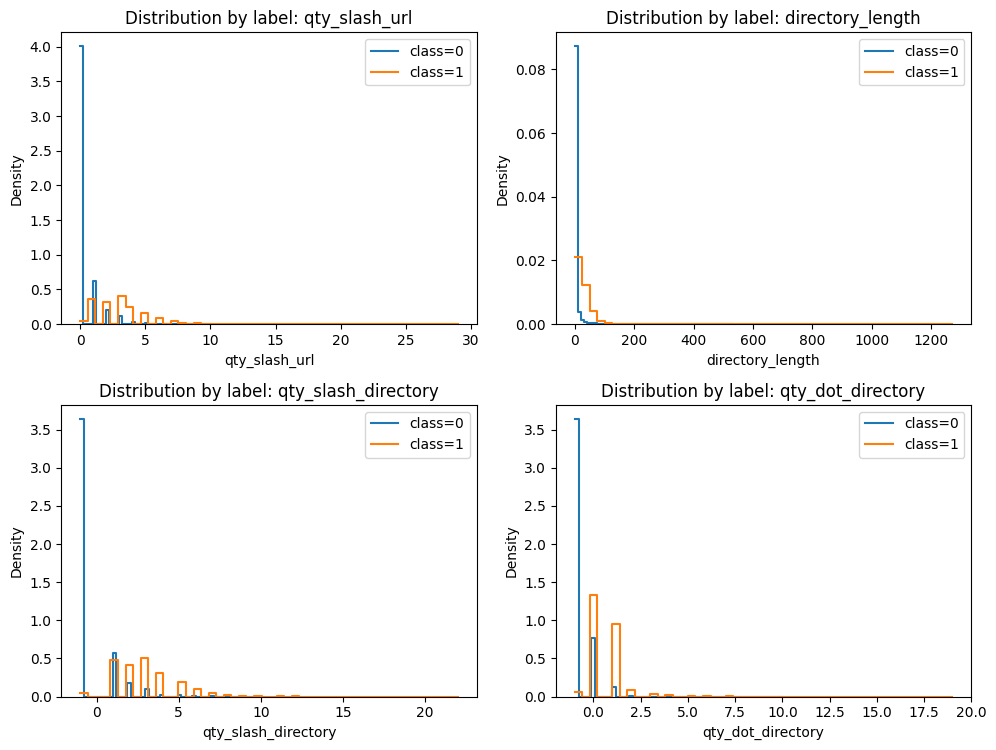


----------------------------------------------------------------------
[12] Boxplots by label (outlier-heavy features)
----------------------------------------------------------------------


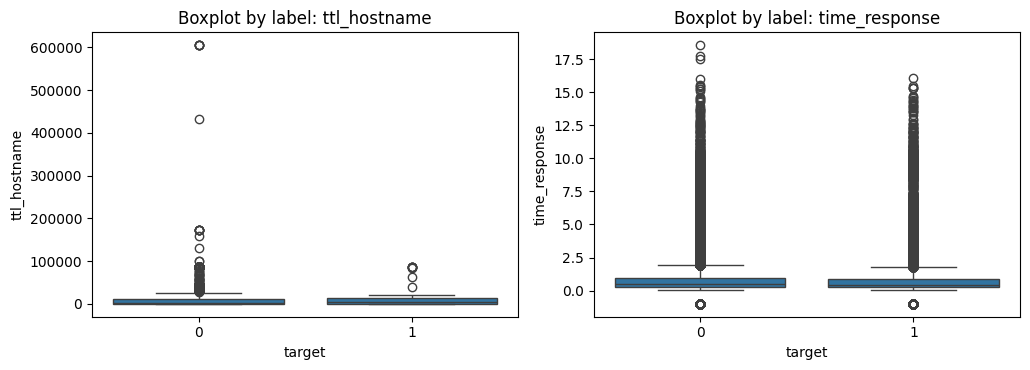


----------------------------------------------------------------------
[13] Correlation heatmap (filtered subset)
----------------------------------------------------------------------


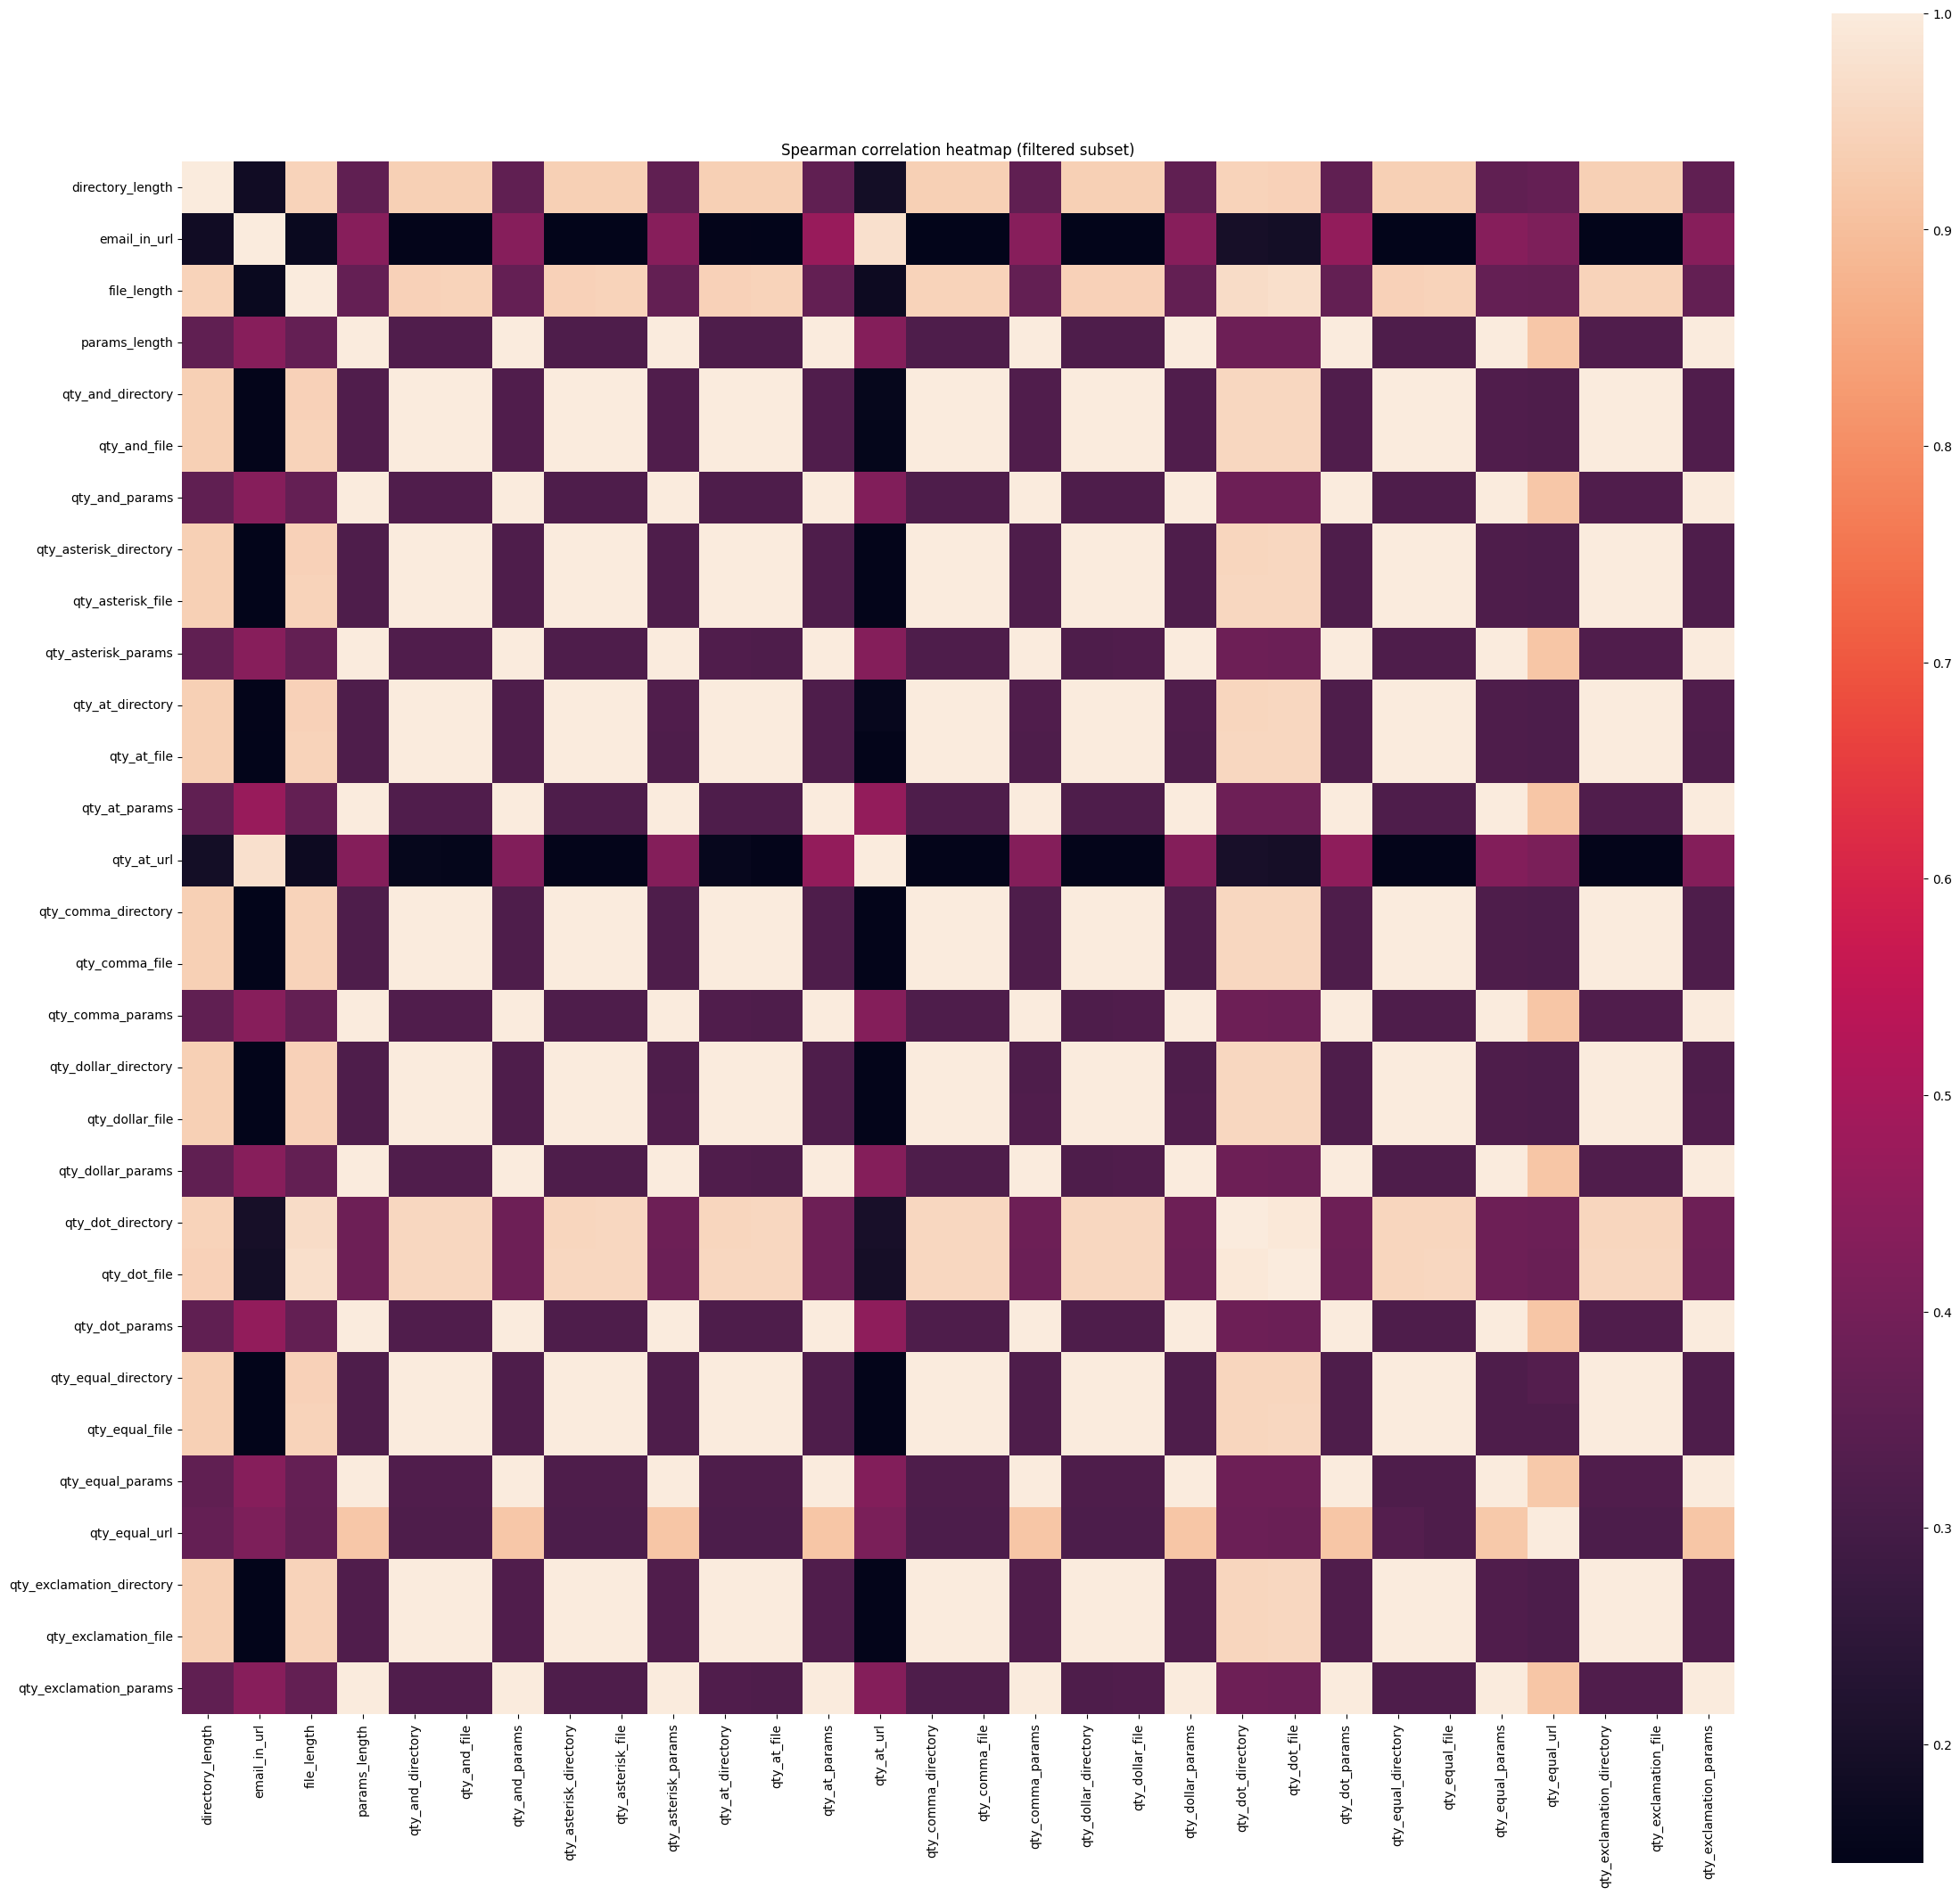

In [ ]:
tables = eda.run_expanded_eda(
    X_train, y_train,
    corr_method="spearman",
    corr_min_abs_for_heatmap=0.90,
    dist_plot_n_features=4,
    boxplot_n_features=2,
    near_constant_threshold=0.99,
    minus1_ratio_threshold=0.01,
    strong_corr_threshold=0.70,
    outlier_ratio_threshold=0.10
)

### EDA Insights

| Insight                                                                                                                                                                                                    | Action                                                                                                                                                              |
| ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Class balance:** Moderate imbalance (~35% phishing).                                                                     | Consider class-weighting or threshold tuning later.                         |
| **Feature types:** Numeric/binary.                                                                                          | No need for categorical encoding.                                  |
| **Missing values:** No missing values. 0/(-1)  likely represent true absence.   | No imputation required.                                                                 |
| **Sentinel values (-1):** Features use -1 for real "N/A".                           | Consider `has_params` etc. indicator.                      |
| **Constant features:** Several are constant --> non-informative.                                                                                                   | Remove.                     |
| **Near-constant features:** Some are almost constant; may carry signal.                                                                                    | Consider removing later.                                          |
| **Predictive signal:** Some strong correlations found --> Prediction is possible.                                            | None.                                                                                            |
| **Leakage:** No feature achieved suspicious predictive power.                                                                         | None.                                                                     |
| **Outliers:** Plausible and may be informative.                                   |  Scale and/or `log1p` for sensitive models. Consider removing later.           |
| **Duplicates:** Identical columns found, no new information & collinearity.                                                              | Drop.                                                     |
| **Feature-groups:** Strong signal in **directory/file**; weak in **external**. | Compare models: All vs. Non-external. |


# Preprocessing

In [ ]:
# Preprocess: fit on train only, transform val/test
prep = preprocess.Preprocessor(minus1_mode="auto", minus1_min_ratio=0.01)

X_train_prep, rep_train = prep.fit_transform(X_train, y_train)
X_val_prep, rep_val = prep.transform(X_val)
X_test_prep, rep_test = prep.transform(X_test)

print("\n=== Preprocess Summary (fitted on train only) ===")
print(prep.summary())

print("\nShapes after preprocessing:")
print(f"Train: {X_train.shape} -> {X_train_prep.shape}")
print(f"Val  : {X_val.shape} -> {X_val_prep.shape}")
print(f"Test : {X_test.shape} -> {X_test_prep.shape}")


=== Preprocess Summary (fitted on train only) ===
{'constant_cols': 13, 'duplicate_cols': 5, 'minus1_mode': 'auto', 'minus1_groups': {'has_path': 31, 'has_params': 20, 'has_time_response': 1, 'has_domain_spf': 1, 'has_asn_ip': 1, 'has_time_domain_activation': 1, 'has_time_domain_expiration': 1, 'has_qty_ip_resolved': 1, 'has_ttl_hostname': 1, 'has_qty_redirects': 1}, 'added_indicator_cols': ['has_path', 'has_params', 'has_time_response', 'has_domain_spf', 'has_asn_ip', 'has_time_domain_activation', 'has_time_domain_expiration', 'has_qty_ip_resolved', 'has_ttl_hostname', 'has_qty_redirects']}

Shapes after preprocessing:
Train: (61046, 111) -> (61046, 103)
Val  : (13081, 111) -> (13081, 103)
Test : (13082, 111) -> (13082, 103)


# Baseline Models

In [ ]:
BASELINE_THRESHOLD = 0.5

# Explicit baseline models
baseline_models = {
    "LogReg (ElasticNet)": models.build_logreg_elasticnet(random_state=RANDOM_STATE),
    "Linear SVM (Calibrated)": models.build_linear_svm_calibrated(random_state=RANDOM_STATE),
    "Random Forest": models.build_random_forest(random_state=RANDOM_STATE),
}

if getattr(models, "HAS_XGB", False):
    baseline_models["XGBoost (GPU if enabled)"] = models.build_xgboost(
        y_train=y_train,
        random_state=RANDOM_STATE,
        use_gpu=True
    )

# Fit & Evaluate
df_baseline, fitted_baseline = eval_utils.run_models_train_val(
    baseline_models,
    X_train_prep, y_train,
    X_val_prep, y_val,
    threshold=0.5,
    verbose=True
)
display(df_baseline)


# Save baseline fitted models
for name, model in fitted_baseline.items():
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")
    path = os.path.join(models_dir, f"BASELINE_{safe_name}.joblib")
    models.save_model(model, path)

print(f"Saved {len(fitted_baseline)} baseline models to: {models_dir}")




[1/4] Training: LogReg (ElasticNet) ... done (fit 676.3s, eval 0.1s). ETA ~2029.2s
[2/4] Training: Linear SVM (Calibrated) ... done (fit 21.1s, eval 0.1s). ETA ~697.6s
[3/4] Training: Random Forest ... done (fit 66.9s, eval 1.4s). ETA ~255.3s
[4/4] Training: XGBoost (GPU if enabled) ... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:43:33] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:43:33] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


done (fit 13.4s, eval 0.3s). ETA ~0.0s


,model,threshold,roc_auc,pr_auc,accuracy,precision,recall,f1,tn,fp,fn,tp
0,Random Forest,0.5,0.995487,0.992183,0.970033,0.954961,0.959554,0.957252,8300,207,185,4389
1,XGBoost (GPU if enabled),0.5,0.995311,0.991563,0.967434,0.940714,0.967862,0.954095,8228,279,147,4427
2,LogReg (ElasticNet),0.5,0.981395,0.966278,0.928752,0.861453,0.948841,0.903038,7809,698,234,4340
3,Linear SVM (Calibrated),0.5,0.981343,0.966248,0.933874,0.895838,0.917578,0.906577,8019,488,377,4197


**RF** came out on top by a small margin, but **XGB** is more advanced and has a high potential for success in tuning hyperparameters. It also supports explainability conveniently. So we will continue with both for now.

# Hyper-parameters Tuning

In [ ]:
# Common settings
CV_SPLITS = 3
SCORING = {"pr_auc": "average_precision", "roc_auc": "roc_auc"}
REFIT = "pr_auc"
VERBOSE = 1

# Random Forest Grid
rf_est = models.build_random_forest(random_state=RANDOM_STATE)

rf_grid = {
    "n_estimators": [600, 1400],
    "max_depth": [None, 6, 25],
    "min_samples_leaf": [1, 4],
    "min_samples_split": [3, 10],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced_subsample"],
}

rf_gs, rf_df = tuning.run_grid_search(
    model_name="RandomForest",
    estimator=rf_est,
    param_grid=rf_grid,
    X=X_train_prep,
    y=y_train,
    scoring=SCORING,
    refit=REFIT,
    n_splits=CV_SPLITS,
    random_state=RANDOM_STATE,
    n_jobs=-1,          # OK for RF
    verbose=VERBOSE
)

display(rf_df.head(15))
print("Best RF params:", rf_gs.best_params_)
print("Best RF PR-AUC:", rf_gs.best_score_)

# XGBoost Grid
# (IMPORTANT: set GridSearch n_jobs=1 to avoid parallel GPU fits)
xgb_est = models.build_xgboost(
    y_train=y_train,
    random_state=RANDOM_STATE,
    use_gpu=True,
    eval_metric="logloss",
)

xgb_grid = {
    "n_estimators": [600, 2000],
    "learning_rate": [0.01, 0.07],
    "max_depth": [3, 8, 25],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.80, 1.0],
    "min_child_weight": [1, 7],
    "gamma": [0, 5],
    "reg_lambda": [1.0, 8.0],
}

xgb_gs, xgb_df = tuning.run_grid_search(
    model_name="XGBoost",
    estimator=xgb_est,
    param_grid=xgb_grid,
    X=X_train_prep,
    y=y_train,
    scoring=SCORING,
    refit=REFIT,
    n_splits=CV_SPLITS,
    random_state=RANDOM_STATE,
    n_jobs=1,           # IMPORTANT for GPU
    verbose=VERBOSE
)

display(xgb_df.head(15))
print("Best XGB params:", xgb_gs.best_params_)
print("Best XGB PR-AUC:", xgb_gs.best_score_)



=== GridSearch: RandomForest ===
CV: StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
Refit metric: pr_auc
Total combinations: 48
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,rank_test_pr_auc,mean_test_pr_auc,std_test_pr_auc,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,mean_score_time,params
0,1,0.990339,0.000591,0.994351,0.000347,151.920269,6.567802,"{'class_weight': 'balanced_subsample', 'max_de..."
1,2,0.990276,0.000561,0.994283,0.000319,139.077430,7.050097,"{'class_weight': 'balanced_subsample', 'max_de..."
2,3,0.990260,0.000610,0.994232,0.000387,120.892478,7.102399,"{'class_weight': 'balanced_subsample', 'max_de..."
3,4,0.990251,0.000585,0.994300,0.000385,65.645379,2.809828,"{'class_weight': 'balanced_subsample', 'max_de..."
4,5,0.990236,0.000630,0.994218,0.000399,54.315350,3.346268,"{'class_weight': 'balanced_subsample', 'max_de..."
5,6,0.990212,0.000563,0.994204,0.000336,51.149546,3.010401,"{'class_weight': 'balanced_subsample', 'max_de..."
6,7,0.990027,0.000598,0.994094,0.000355,115.202778,6.016858,"{'class_weight': 'balanced_subsample', 'max_de..."
7,8,0.990018,0.000575,0.994085,0.000344,52.659996,3.738647,"{'class_weight': 'balanced_subsample', 'max_de..."
8,9,0.989370,0.000591,0.993800,0.000348,144.656996,6.565043,"{'class_weight': 'balanced_subsample', 'max_de..."
9,10,0.989305,0.000578,0.993765,0.000349,138.298940,6.315271,"{'class_weight': 'balanced_subsample', 'max_de..."


Best RF params: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400}
Best RF PR-AUC: 0.9903388903337834

=== GridSearch: XGBoost ===
CV: StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
Refit metric: pr_auc
Total combinations: 384
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [22:13:43] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


,rank_test_pr_auc,mean_test_pr_auc,std_test_pr_auc,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,mean_score_time,params
0,1,0.991440,0.000681,0.995041,0.000294,28.768932,0.269410,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
1,2,0.991430,0.000545,0.995009,0.000241,27.969794,0.276752,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
2,3,0.991413,0.000590,0.995028,0.000236,2.621773,0.102485,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
3,4,0.991355,0.000616,0.994980,0.000281,8.432402,0.166818,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
4,5,0.991290,0.000491,0.994885,0.000209,2.639422,0.074976,"{'colsample_bytree': 1.0, 'gamma': 0, 'learnin..."
5,6,0.991275,0.000565,0.994907,0.000239,27.846889,0.262120,"{'colsample_bytree': 1.0, 'gamma': 0, 'learnin..."
6,7,0.991242,0.000635,0.994919,0.000284,29.766254,0.267671,"{'colsample_bytree': 1.0, 'gamma': 0, 'learnin..."
7,8,0.991238,0.000672,0.994906,0.000303,8.476151,0.173443,"{'colsample_bytree': 1.0, 'gamma': 0, 'learnin..."
8,9,0.991231,0.000660,0.994910,0.000290,31.455248,0.285554,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
9,10,0.991173,0.000747,0.994885,0.000328,7.061806,0.100743,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."


Best XGB params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 25, 'min_child_weight': 1, 'n_estimators': 2000, 'reg_lambda': 8.0, 'subsample': 0.8}
Best XGB PR-AUC: 0.9914396274771714
Saved best models:
 - /content/drive/MyDrive/לימודים/תואר שני/סמסטר3/סייבר/project/models
 - /content/drive/MyDrive/לימודים/תואר שני/סמסטר3/סייבר/project/models


### Run the selected models on the train set and evaluate on val set:

In [ ]:
# Config
RF_MODEL_PATH = os.path.join(models_dir, "RF_best.joblib")
XGB_MODEL_PATH = os.path.join(models_dir, "XGB_best.joblib")

rf_best_params = {
    "class_weight": "balanced_subsample",
    "max_depth": None,
    "max_features": "sqrt",
    "min_samples_leaf": 1,
    "min_samples_split": 3,
    "n_estimators": 1400
}

xgb_best_params = {
    "colsample_bytree": 0.8,
    "gamma": 0,
    "learning_rate": 0.01,
    "max_depth": 25,
    "min_child_weight": 1,
    "n_estimators": 2000,
    "reg_lambda": 8.0,
    "subsample": 0.8
}

THRESHOLD = 0.5

print("Using RF params:", rf_best_params)
print("Using XGB params:", xgb_best_params)

# Build models
rf_model = models.build_random_forest(random_state=RANDOM_STATE, **rf_best_params)
xgb_model = models.build_xgboost(
    y_train=y_train,
    random_state=RANDOM_STATE,
    use_gpu=True,
    eval_metric=["aucpr", "logloss"],
    **xgb_best_params
)

# Fit
print("\n[Fit] Random Forest...")
rf_model.fit(X_train_prep, y_train)

print("[Fit] XGBoost...")
xgb_model.fit(
    X_train_prep, y_train,
    eval_set=[(X_train_prep, y_train), (X_val_prep, y_val)],
    verbose=False
)

# Evaluate on Validation
print("\n[Eval] Validation metrics (threshold=0.5)")
models_dict = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

df_val, fitted_models = eval_utils.run_models_train_val(
    models_dict,
    X_train_prep, y_train,
    X_val_prep, y_val,
    threshold=THRESHOLD,
    verbose=True
)

display(df_val)

# Save
joblib.dump(rf_model, RF_MODEL_PATH)
joblib.dump(xgb_model, XGB_MODEL_PATH)
print("\nSaved models:")
print(" -", RF_MODEL_PATH)
print(" -", XGB_MODEL_PATH)

# Sanity: show if XGB has evals history inside the fitted object
has_evals = hasattr(xgb_model, "evals_result_") and (xgb_model.evals_result_ is not None)
print("XGB evals_result_ available inside model:", has_evals)


Using RF params: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400}
Using XGB params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 25, 'min_child_weight': 1, 'n_estimators': 2000, 'reg_lambda': 8.0, 'subsample': 0.8}

[Fit] Random Forest...
[Fit] XGBoost...

[Eval] Validation metrics (threshold=0.5)
[1/2] Training: Random Forest ... done (fit 32.7s, eval 0.6s). ETA ~33.3s
[2/2] Training: XGBoost ... 

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [09:37:30] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


done (fit 39.4s, eval 0.2s). ETA ~0.0s


,model,threshold,roc_auc,pr_auc,accuracy,precision,recall,f1,tn,fp,fn,tp
0,XGBoost,0.5,0.996260,0.993358,0.973320,0.956757,0.967425,0.962061,8307,200,149,4425
1,Random Forest,0.5,0.995588,0.992266,0.969804,0.952175,0.961959,0.957042,8286,221,174,4400



Saved models:
 - /content/drive/MyDrive/לימודים/תואר שני/סמסטר3/סייבר/project/models/RF_best.joblib
 - /content/drive/MyDrive/לימודים/תואר שני/סמסטר3/סייבר/project/models/XGB_best.joblib
XGB evals_result_ available inside model: True


We'll continue from here with **XGBoost** alone. Results came out a bit better, it runs faster (GPU), and is more flexible for future tuning.

### Some Vis:

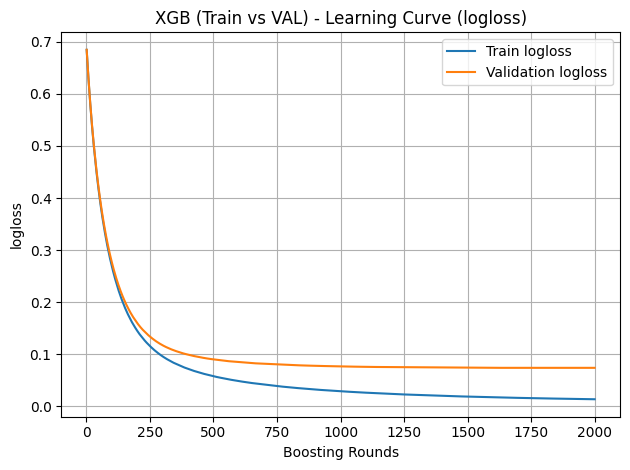

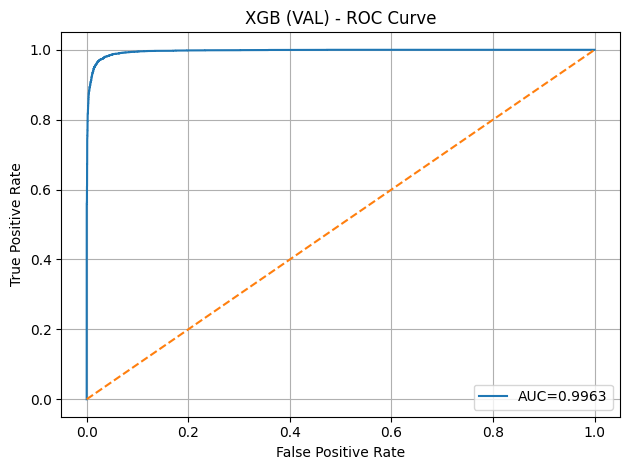

In [ ]:
# Scores on validation
scores_val = eval_utils.get_scores(xgb_model, X_val_prep)

# Learning curve (logloss) from the fitted XGB model (requires eval_set + logloss)
eval_utils.plot_xgb_learning_curve_logloss(
    xgb_model,
    title="XGB (Train vs VAL) - Learning Curve (logloss)"
)

# ROC curve on validation
eval_utils.plot_roc_curve(
    y_val,
    scores_val,
    title="XGB (VAL) - ROC Curve"
)


| Insight                                                                                           | Action / Decision                                                        |
| ------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------ |
| **XGBoost performance is good.**                       | Keep XGB as the single final model.                                      |
| **Learning curve:** Validation improves and plateaus; mild train–val gap only.          | No urgent overfitting fix; consider early-stopping later for efficiency. |

# Impact of Classification Threshold

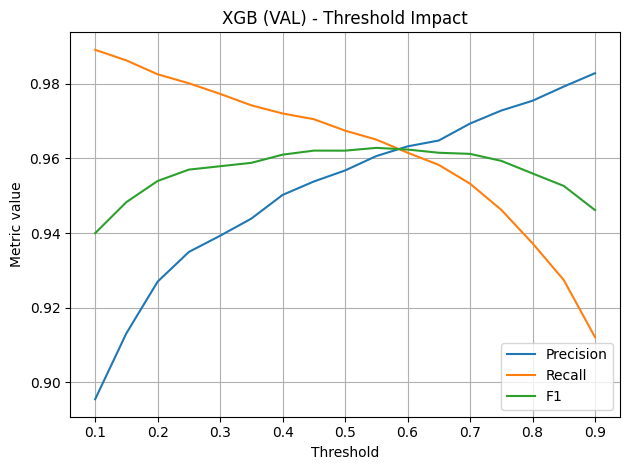

Policy thresholds: {'alert_first': 0.25, 'balanced': 0.55, 'block_first': 0.9}


In [ ]:
XGB_MODEL_PATH = os.path.join(models_dir, "XGB_best.joblib")
xgb_model = joblib.load(XGB_MODEL_PATH)

# Scores on validation
scores_val = eval_utils.get_scores(xgb_model, X_val_prep)

# Sweep thresholds
threshold_grid = [round(t, 2) for t in np.linspace(0.1, 0.9, 17)]
df_thr = eval_utils.threshold_sweep(scores_val, y_val, thresholds=threshold_grid)

# Plot only the threshold impact
eval_utils.plot_threshold_impact(
    df_thr,
    title="XGB (VAL) - Threshold Impact",
    metrics=("precision", "recall", "f1"),
    zoom=True
)

# Pick 3 policy thresholds
policy_thr = eval_utils.pick_policy_thresholds(
    df_thr,
    recall_target=0.98,
    precision_target=0.98
)

print("Policy thresholds:", policy_thr)


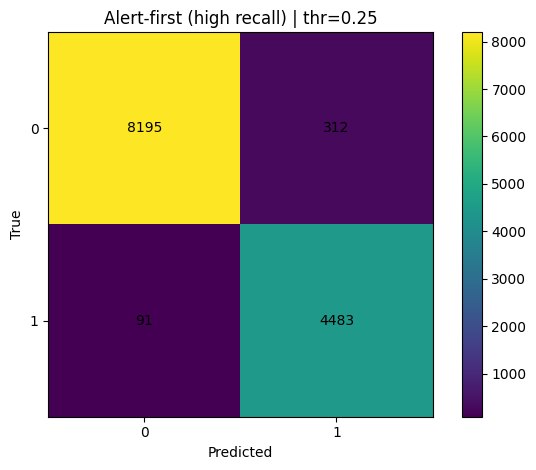

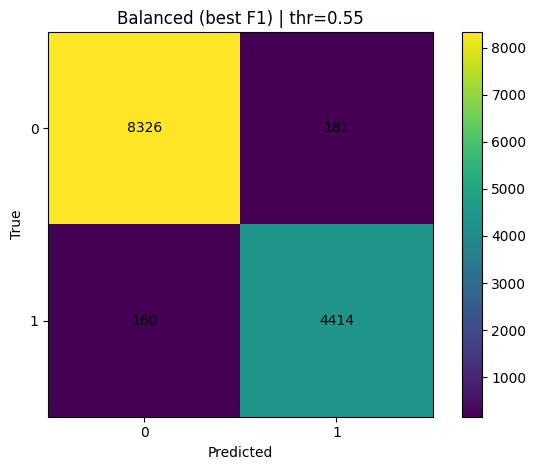

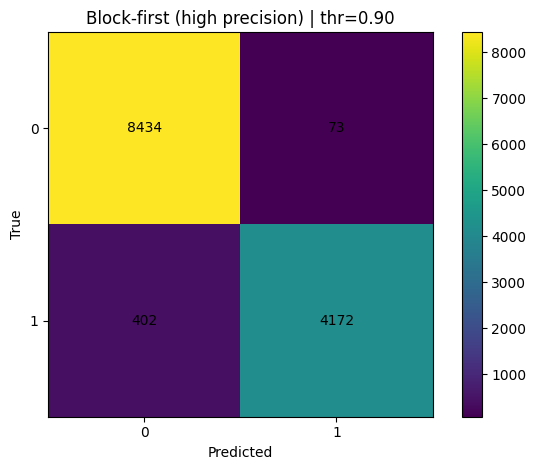

In [ ]:
eval_utils.plot_three_policy_confusion_matrices(
    y_val,
    scores_val,
    policy_thr
)


Decision threshold changes the balance between missed phishing attempts and false alerts.


A low threshold (0.25) catches almost all phishing.

A mid-range threshold (0.55) provides the best balance between false positives and false negatives, general default.

A high threshold (0.90) avoids blocking legitimate sites but will miss more phishing attempts.



# 'No-External-Features' Classification

In [ ]:
# Identify & filter columns from original X-sets
cols_to_keep = eda.get_feature_list(X_train, exclude_groups=["external"])
X_train_noext = eda.select_features(X_train, cols_to_keep)
X_val_noext = eda.select_features(X_val, cols_to_keep)
X_test_noext = eda.select_features(X_test, cols_to_keep)

# Number of features removed
n_removed = X_train.shape[1] - X_train_noext.shape[1]

print("\n=== Feature Filtering Report (No External) ===")
print(f"Features removed: {n_removed}")
print(f"Train shape: {X_train.shape} -> {X_train_noext.shape}")
print(f"Val   shape: {X_val.shape}   -> {X_val_noext.shape}")
print(f"Test  shape: {X_test.shape}  -> {X_test_noext.shape}")


################################

# Preprocess
prep2 = preprocess.Preprocessor(minus1_mode="auto", minus1_min_ratio=0.01)

X_train_noext_prep, rep_noext_train = prep2.fit_transform(X_train_noext, y_train)
X_val_noext_prep, rep_noext_val = prep2.transform(X_val_noext)
X_test_noext_prep, rep_noext_test = prep2.transform(X_test_noext)

print("\n=== Preprocess Summary (No External) ===")
print(prep2.summary())

print("\nShapes after preprocessing:")
print(f"Train: {X_train_noext.shape} -> {X_train_noext_prep.shape}")
print(f"Val  : {X_val_noext.shape} -> {X_val_noext_prep.shape}")
print(f"Test : {X_test_noext.shape} -> {X_test_noext_prep.shape}")


=== Feature Filtering Report (No External) ===
Features removed: 14
Train shape: (61046, 111) -> (61046, 97)
Val   shape: (13081, 111)   -> (13081, 97)
Test  shape: (13082, 111)  -> (13082, 97)

=== Preprocess Summary (No External) ===
{'constant_cols': 13, 'duplicate_cols': 5, 'minus1_mode': 'auto', 'minus1_groups': {'has_path': 31, 'has_params': 20}, 'added_indicator_cols': ['has_path', 'has_params']}

Shapes after preprocessing:
Train: (61046, 97) -> (61046, 81)
Val  : (13081, 97) -> (13081, 81)
Test : (13082, 97) -> (13082, 81)


### Hyper-parameter Tuning (No External)

XGB only

In [ ]:
# Common settings
CV_SPLITS = 3
SCORING = {"pr_auc": "average_precision", "roc_auc": "roc_auc"}
REFIT = "pr_auc"
VERBOSE = 1

# XGBoost_noext Grid (same as earlier)
xgb_est_noext = models.build_xgboost(
    y_train=y_train,
    random_state=RANDOM_STATE,
    use_gpu=True,
    eval_metric="logloss",
)

xgb_grid = {
    "n_estimators": [600, 2000],
    "learning_rate": [0.01, 0.07],
    "max_depth": [3, 8, 25],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.80, 1.0],
    "min_child_weight": [1, 7],
    "gamma": [0, 5],
    "reg_lambda": [1.0, 8.0],
}

xgb_gs_noext, xgb_df_noext = tuning.run_grid_search(
    model_name="XGBoost",
    estimator=xgb_est_noext,
    param_grid=xgb_grid,
    X=X_train_noext_prep,
    y=y_train,
    scoring=SCORING,
    refit=REFIT,
    n_splits=CV_SPLITS,
    random_state=RANDOM_STATE,
    n_jobs=1,           # IMPORTANT for GPU
    verbose=VERBOSE
)

display(xgb_df_noext.head(15))
print("Best XGB params:", xgb_gs_noext.best_params_)
print("Best XGB PR-AUC:", xgb_gs_noext.best_score_)


=== GridSearch: XGBoost ===
CV: StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
Refit metric: pr_auc
Total combinations: 384
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


,rank_test_pr_auc,mean_test_pr_auc,std_test_pr_auc,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,mean_score_time,params
0,1,0.969825,0.001151,0.980982,0.000575,6.807224,0.093816,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
1,2,0.969764,0.001236,0.980944,0.000586,7.012229,0.099498,"{'colsample_bytree': 1.0, 'gamma': 0, 'learnin..."
2,3,0.969635,0.000915,0.980887,0.000491,2.252464,0.062293,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
3,4,0.969522,0.001164,0.980598,0.000604,24.969365,0.181159,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
4,5,0.969462,0.000991,0.980812,0.000457,1.814562,0.057799,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
5,6,0.969441,0.001040,0.980875,0.000500,1.782165,0.054930,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
6,7,0.969354,0.001011,0.980699,0.000468,2.347188,0.061514,"{'colsample_bytree': 1.0, 'gamma': 0, 'learnin..."
7,8,0.969256,0.001158,0.980806,0.000591,7.075167,0.094794,"{'colsample_bytree': 1.0, 'gamma': 0, 'learnin..."
8,9,0.969256,0.001229,0.980611,0.000577,1.794751,0.056199,"{'colsample_bytree': 1.0, 'gamma': 0, 'learnin..."
9,10,0.969190,0.001119,0.980775,0.000579,6.844785,0.093516,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."


Best XGB params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 2000, 'reg_lambda': 1.0, 'subsample': 0.8}
Best XGB PR-AUC: 0.969825117451863


### Fit on Train and Evaluate

Using XGB params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 2000, 'reg_lambda': 1.0, 'subsample': 0.8}
[Build] Building XGBoost model...
[Fit] Training XGBoost model...

Saved model:
 - /content/drive/MyDrive/לימודים/תואר שני/סמסטר3/סייבר/project/models/no_external/XGB_noext_best.joblib

[Eval] Validation metrics (threshold=0.5)
[1/1] Training: XGBoost ... done (fit 7.6s, eval 0.1s). ETA ~0.0s


,model,threshold,roc_auc,pr_auc,accuracy,precision,recall,f1,tn,fp,fn,tp
0,XGBoost,0.5,0.981455,0.971478,0.929669,0.876236,0.930258,0.902439,7906,601,319,4255


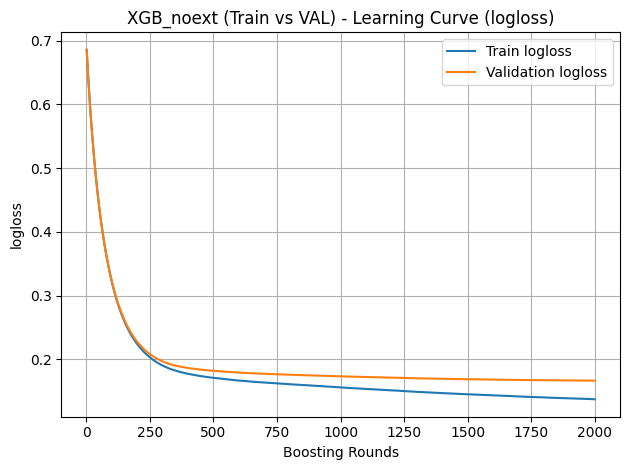

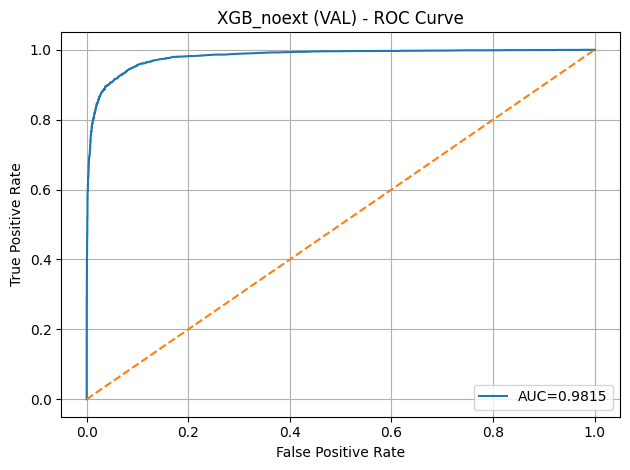

In [ ]:
# Config
XGB_noext_MODEL_PATH = os.path.join(models_noext_dir, "XGB_noext_best.joblib")

# Best parmeters changed: 'max_depth': 25->8, 'reg_lambda': 8.0->1.0,
xgb_noext_best_params = {"colsample_bytree": 0.8,"gamma": 0,"learning_rate": 0.01,"max_depth": 8,"min_child_weight": 1,"n_estimators": 2000,"reg_lambda": 1.0,"subsample": 0.8}

THRESHOLD = 0.5

print("Using XGB params:", xgb_noext_best_params)

# Build & Train Model
print("[Build] Building XGBoost model...")
xgb_noext_model = models.build_xgboost(
    y_train=y_train,
    random_state=RANDOM_STATE,
    use_gpu=True,
    eval_metric=["aucpr", "logloss"],
    **xgb_noext_best_params
)
# Train
print("[Fit] Training XGBoost model...")
xgb_noext_model.fit(
    X_train_noext_prep, y_train,
    eval_set=[(X_train_noext_prep, y_train), (X_val_noext_prep, y_val)],
    verbose=False
)
# Save
joblib.dump(xgb_noext_model, XGB_noext_MODEL_PATH)
print("\nSaved model:")
print(" -", XGB_noext_MODEL_PATH)

# Evaluate on Validation
print("\n[Eval] Validation metrics (threshold=0.5)")
models_dict = {"XGBoost": xgb_noext_model}

df_val, fitted_models = eval_utils.run_models_train_val(
    {"XGBoost": xgb_noext_model},
    X_train_noext_prep, y_train,
    X_val_noext_prep, y_val,
    threshold=THRESHOLD,
    verbose=True
)

display(df_val)

#############
# Vis
# Scores on validation
scores_val_noext = eval_utils.get_scores(xgb_noext_model, X_val_noext_prep)

# Learning curve
eval_utils.plot_xgb_learning_curve_logloss(
    xgb_noext_model,
    title="XGB_noext (Train vs VAL) - Learning Curve (logloss)"
)

# ROC curve
eval_utils.plot_roc_curve(
    y_val,
    scores_val_noext,
    title="XGB_noext (VAL) - ROC Curve"
)

### Classification Threshold (No External)

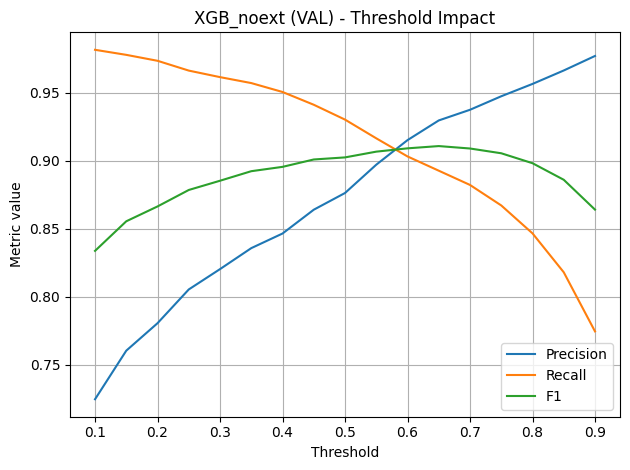

Policy thresholds (no external): {'alert_first': 0.1, 'balanced': 0.65, 'block_first': 0.9}


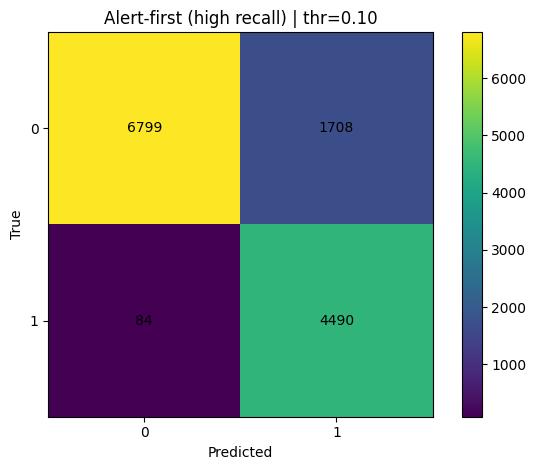

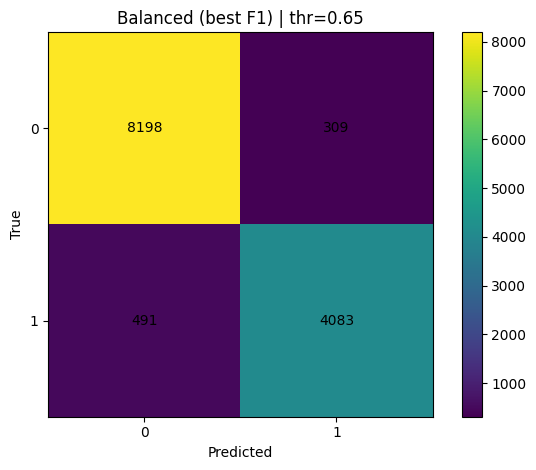

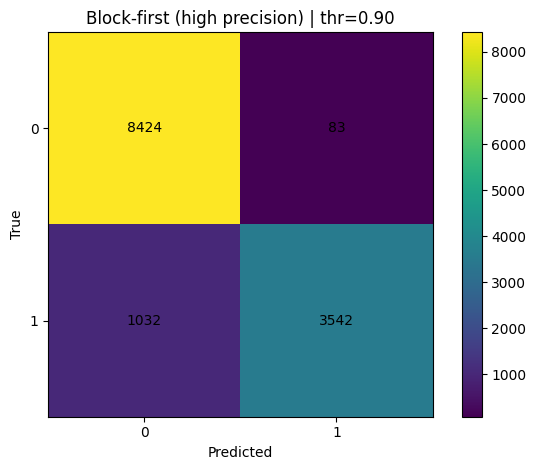

In [ ]:
# Sweep thresholds
threshold_grid = [round(t, 2) for t in np.linspace(0.1, 0.9, 17)]
df_thr = eval_utils.threshold_sweep(scores_val_noext, y_val, thresholds=threshold_grid)

# Plot only the threshold impact
eval_utils.plot_threshold_impact(
    df_thr,
    title="XGB_noext (VAL) - Threshold Impact",
    metrics=("precision", "recall", "f1"),
    zoom=True
)

# Pick 3 policy thresholds
policy_thr_noext = eval_utils.pick_policy_thresholds(
    df_thr,
    recall_target=0.98,
    precision_target=0.98
)

print("Policy thresholds (no external):", policy_thr_noext)

eval_utils.plot_three_policy_confusion_matrices(
    y_val,
    scores_val_noext,
    policy_thr_noext
)

Removing the 14 external features reduced dimensionality (111 → 81 columns) and allowed for a simpler model structure (optimal max_depth dropped to 8). While the metric drop appears moderate (ROC-AUC: 0.996 → 0.981; PR-AUC: 0.993 → 0.971), the operational impact is significant. The 'lighter' model lacks the confidence of the full model, forcing a shift in decision thresholds: to maintain high recall (Alert-first), the threshold must be aggressively lowered (0.25 → 0.10) to capture subtle phishing signals. Conclusion: Keep external features for high-precision blocking tasks; use the simplified model only if the goal is broad suspicion detection where false alarms are tolerable.

A comparison of the confusion matrices reveals the specific cost of removing external features: in the Block-first strategy (high precision), the simplified model misses significantly more attacks (~600 fewer detections) to maintain safety. Conversely, in the Alert-first strategy, the lack of strong features forces the model to lower its threshold, causing False Positives to spike by over 500% (from 312 to 1,721) just to achieve comparable recall.

# Check Models on Test Set

Loaded:
 - /content/drive/MyDrive/לימודים/תואר שני/סמסטר3/סייבר/project/models/XGB_best.joblib
 - /content/drive/MyDrive/לימודים/תואר שני/סמסטר3/סייבר/project/models/no_external/XGB_noext_best.joblib

=== TEST AUC Metrics (threshold-free) ===
Full    | ROC-AUC=0.996258 | PR-AUC=0.993453
No-ext  | ROC-AUC=0.981095 | PR-AUC=0.971511

=== TEST Results @ Policy Thresholds ===


,model,policy,threshold,roc_auc,pr_auc,accuracy,precision,recall,f1,tn,fp,fn,tp
0,XGB_full,alert_first,0.25,0.996258,0.993453,0.971029,0.939648,0.980109,0.959452,8219,288,91,4484
1,XGB_full,balanced,0.55,0.996258,0.993453,0.973551,0.963198,0.961093,0.962144,8339,168,178,4397
2,XGB_full,block_first,0.90,0.996258,0.993453,0.962697,0.985969,0.906230,0.944419,8448,59,429,4146
3,XGB_noext,alert_first,0.10,0.981095,0.971511,0.862789,0.725065,0.978798,0.833039,6809,1698,97,4478
4,XGB_noext,balanced,0.65,0.981095,0.971511,0.936936,0.928866,0.887650,0.907790,8196,311,514,4061
5,XGB_noext,block_first,0.90,0.981095,0.971511,0.912399,0.979580,0.765464,0.859387,8434,73,1073,3502


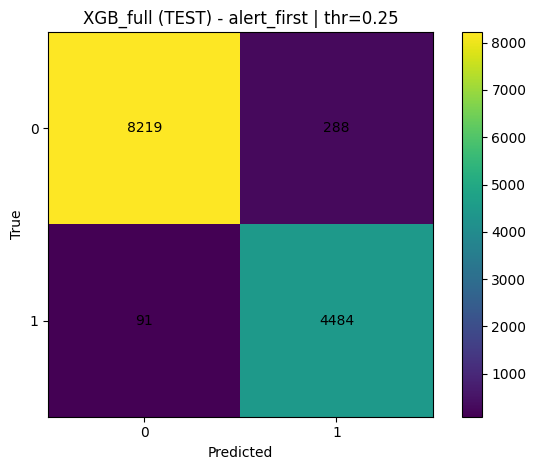

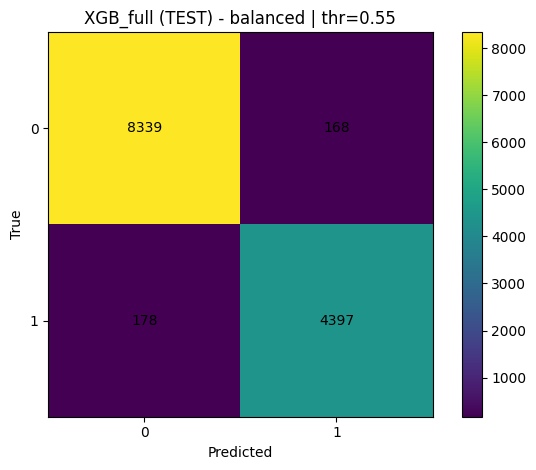

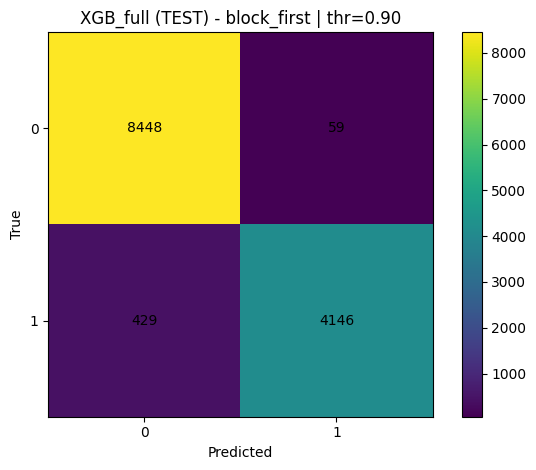

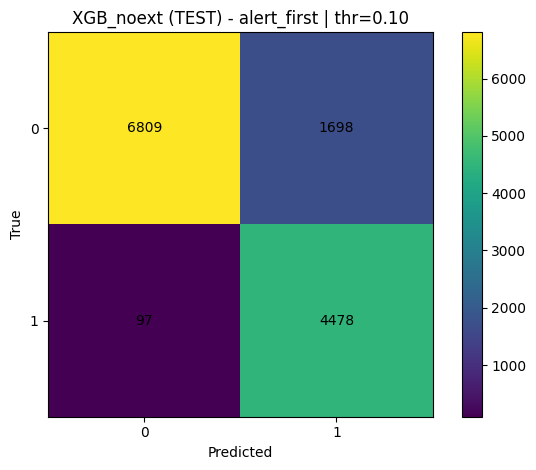

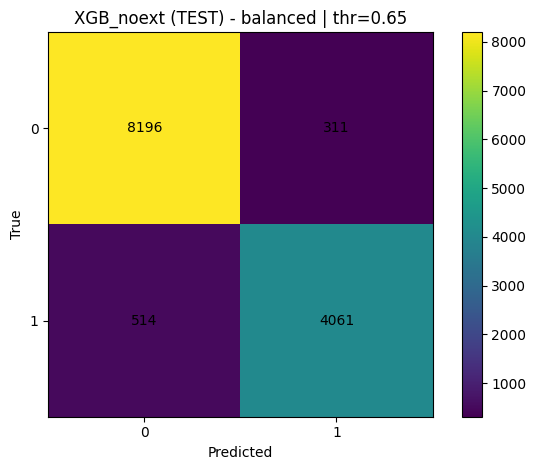

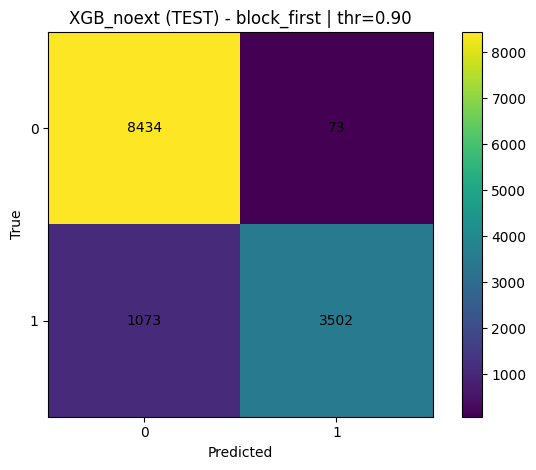

In [ ]:
# =========================
# FINAL TEST EVALUATION
# =========================
# --- Paths & Loads ---
XGB_MODEL_PATH = os.path.join(models_dir, "XGB_best.joblib")
XGB_noext_MODEL_PATH = os.path.join(models_noext_dir, "XGB_noext_best.joblib")

xgb_full = joblib.load(XGB_MODEL_PATH)
xgb_noext = joblib.load(XGB_noext_MODEL_PATH)

print("Loaded:")
print(" -", XGB_MODEL_PATH)
print(" -", XGB_noext_MODEL_PATH)

# --- Score on TEST ---
proba_full = eval_utils.get_scores(xgb_full, X_test_prep)
proba_noext = eval_utils.get_scores(xgb_noext, X_test_noext_prep)

# --- Summary AUC metrics ---
test_full_auc = {
    "roc_auc": float(eval_utils.roc_auc_score(np.asarray(y_test).astype(int), proba_full)),
    "pr_auc": float(eval_utils.average_precision_score(np.asarray(y_test).astype(int), proba_full)),
}
test_noext_auc = {
    "roc_auc": float(eval_utils.roc_auc_score(np.asarray(y_test).astype(int), proba_noext)),
    "pr_auc": float(eval_utils.average_precision_score(np.asarray(y_test).astype(int), proba_noext)),
}

print("\n=== TEST AUC Metrics (threshold-free) ===")
print("Full    | ROC-AUC={roc_auc:.6f} | PR-AUC={pr_auc:.6f}".format(**test_full_auc))
print("No-ext  | ROC-AUC={roc_auc:.6f} | PR-AUC={pr_auc:.6f}".format(**test_noext_auc))

# --- Evaluate at 3 policy thresholds for each model ---
rows = []

# Changed evaluate_binary -> evaluate_from_scores (The new function we added)
for policy_name, thr in policy_thr.items():
    m = eval_utils.evaluate_from_scores(y_test, proba_full, threshold=thr)
    rows.append({"model": "XGB_full", "policy": policy_name, **m})

for policy_name, thr in policy_thr_noext.items():
    m = eval_utils.evaluate_from_scores(y_test, proba_noext, threshold=thr)
    rows.append({"model": "XGB_noext", "policy": policy_name, **m})

df_test = pd.DataFrame(rows)[
    ["model", "policy", "threshold", "roc_auc", "pr_auc", "accuracy", "precision", "recall", "f1", "tn", "fp", "fn", "tp"]
].sort_values(["model", "policy"]).reset_index(drop=True)

print("\n=== TEST Results @ Policy Thresholds ===")
display(df_test)

# --- Confusion matrices (3 per model) ---
for policy_name, thr in policy_thr.items():
    eval_utils.plot_confusion_matrix_from_scores(
        y_true=y_test,
        scores=proba_full,
        threshold=thr,
        title=f"XGB_full (TEST) - {policy_name} | thr={thr:.2f}"
    )

for policy_name, thr in policy_thr_noext.items():
    eval_utils.plot_confusion_matrix_from_scores(
        y_true=y_test,
        scores=proba_noext,
        threshold=thr,
        title=f"XGB_noext (TEST) - {policy_name} | thr={thr:.2f}"
    )

# Some Explainability

Computing explanations for XGBoost (Test Set - Full Data)...

PLOT: Native Feature Importance (gain)
------------------------------------------------------------
WHAT IT SHOWS: The most 'useful' features for the model during training.
HOW TO READ:   Longer bars = Higher contribution to reducing prediction error (loss).
EXAMPLE:       Does NOT show direction (good vs. bad), only magnitude.


<Figure size 1000x800 with 0 Axes>

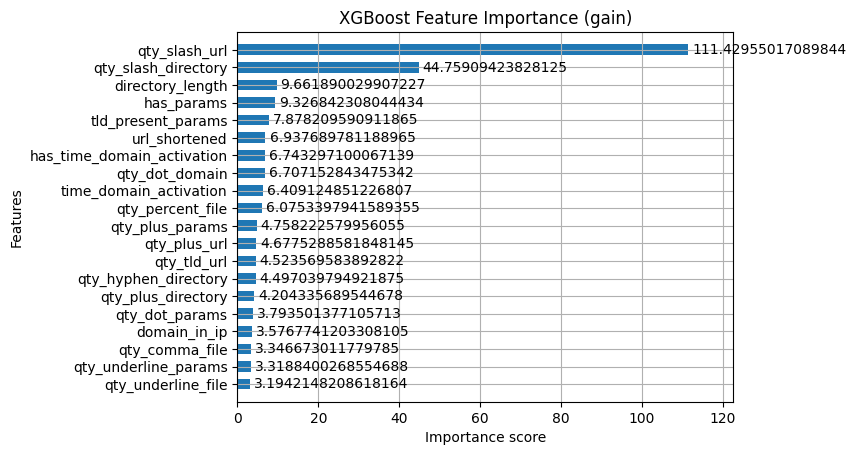


[INFO] Computing SHAP values...

PLOT: Global SHAP Summary (Beeswarm)
------------------------------------------------------------
WHAT IT SHOWS: Feature importance + Direction of impact + Data distribution.
HOW TO READ:   Y-Axis=Importance, X-Axis=Impact (Right=Phishing, Left=Legit), Color=Value.
EXAMPLE:       Red dots on the RIGHT mean High Values increase Phishing risk.


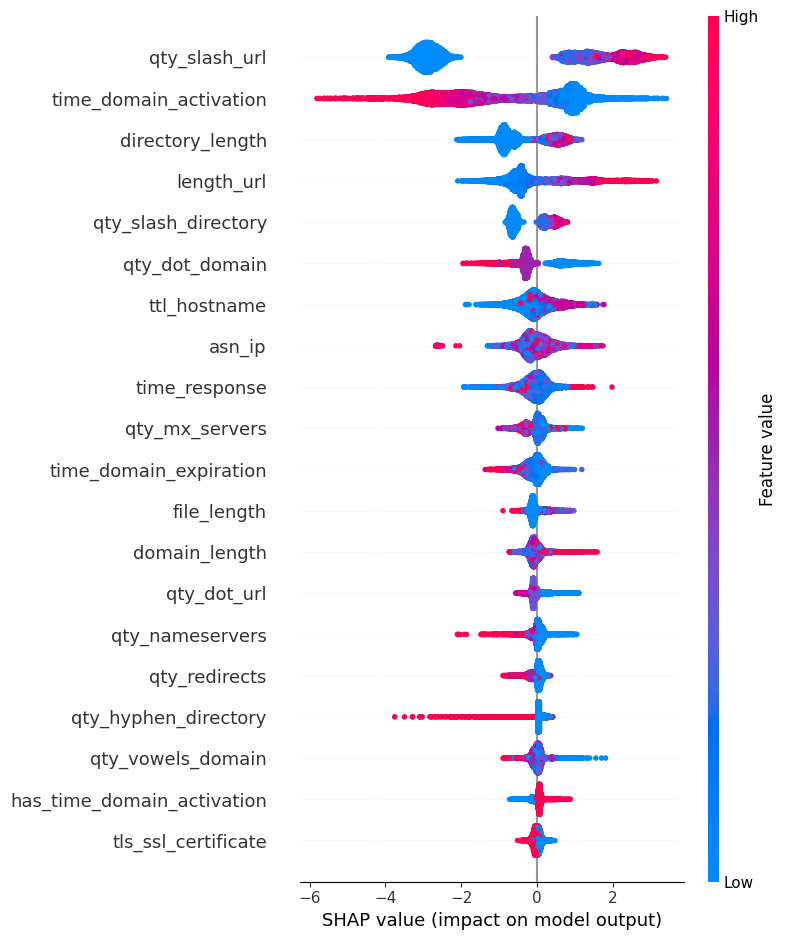


PLOT: Feature Importance by Semantic Group
------------------------------------------------------------
WHAT IT SHOWS: Aggregated impact of feature categories (URL, Domain, External, etc.).
HOW TO READ:   Longer bars = The entire category has a stronger total impact.


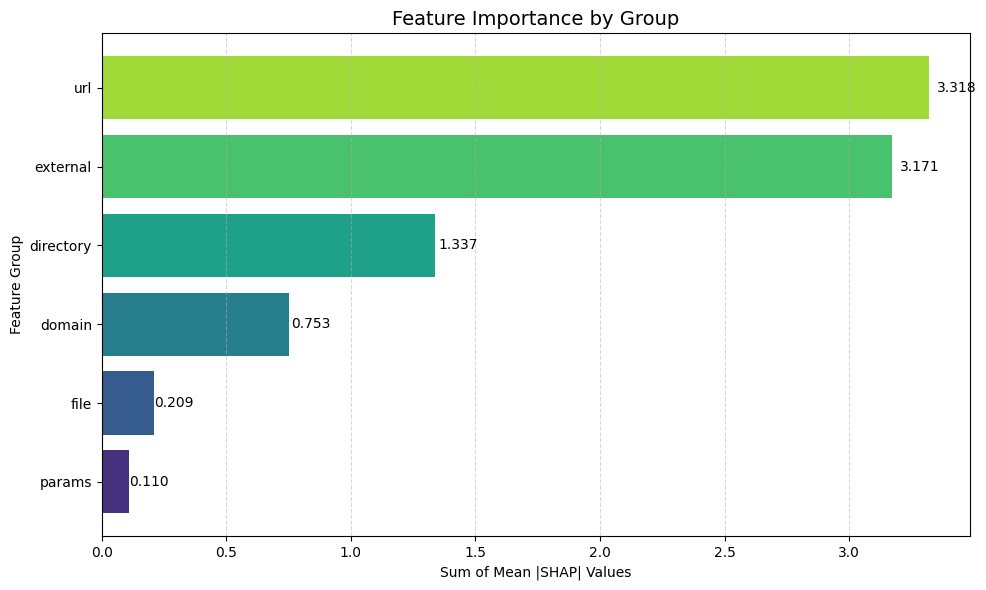


PLOT: Local Error Analysis
------------------------------------------------------------
Selecting representative cases (TP, FP, FN) for deep-dive...
Counts: TP=4367, FP=140, FN=208

>>> CASE: False Positive (Alarm on legit) | Index: 143 | True: 0 | Score: 0.7941

--- Analyzing Instance Index: 143 ---
READING GUIDE (Bottom to Top):
  1. Start at E[f(x)]: Average dataset score.
  2. RED arrows:  Features pushing score HIGHER (Risk).
  3. BLUE arrows: Features pushing score LOWER (Safe).
  4. f(x):        Final prediction score.


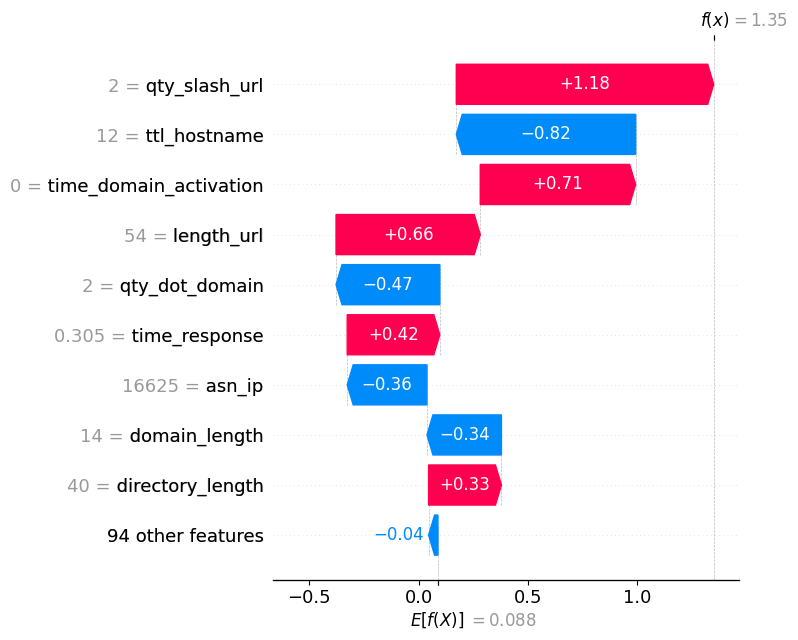


>>> CASE: False Negative (Missed phishing) | Index: 15 | True: 1 | Score: 0.0391

--- Analyzing Instance Index: 15 ---
READING GUIDE (Bottom to Top):
  1. Start at E[f(x)]: Average dataset score.
  2. RED arrows:  Features pushing score HIGHER (Risk).
  3. BLUE arrows: Features pushing score LOWER (Safe).
  4. f(x):        Final prediction score.


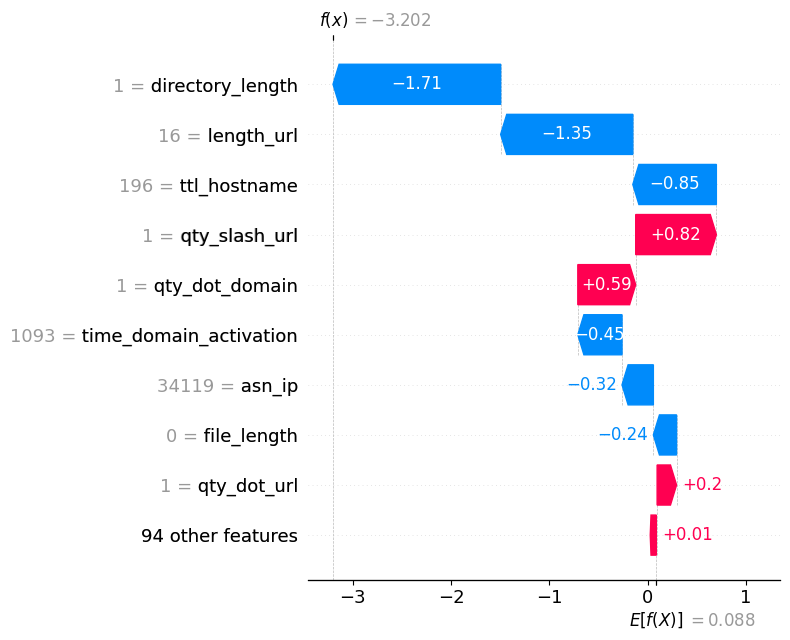


>>> CASE: True Positive (Correct Catch) | Index: 0 | True: 1 | Score: 0.9990

--- Analyzing Instance Index: 0 ---
READING GUIDE (Bottom to Top):
  1. Start at E[f(x)]: Average dataset score.
  2. RED arrows:  Features pushing score HIGHER (Risk).
  3. BLUE arrows: Features pushing score LOWER (Safe).
  4. f(x):        Final prediction score.


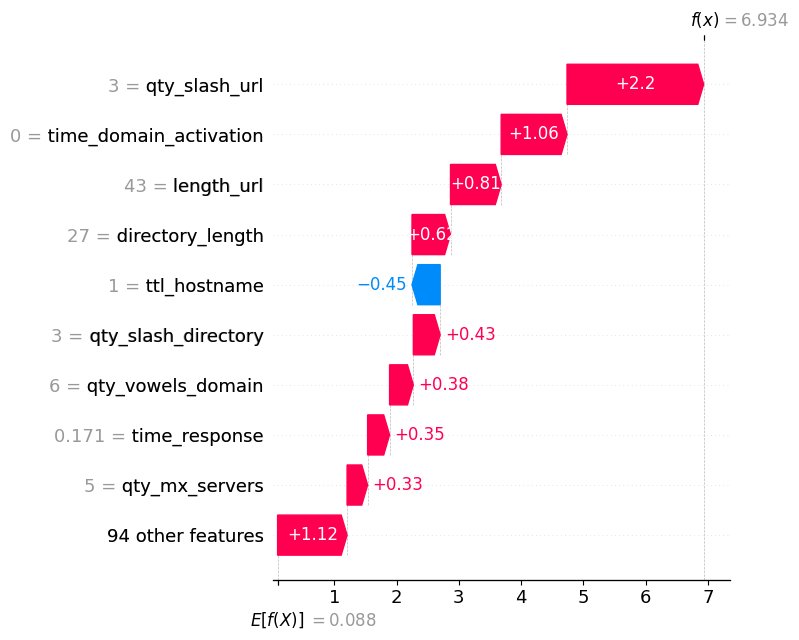

In [ ]:
# Initialize JavaScript for SHAP plots
shap.initjs()

print("Computing explanations for XGBoost (Test Set - Full Data)...")

# 1. XGBoost Built-in Importance (Global)
explain_utils.plot_xgb_importance(xgb_full, importance_type='gain')

# 2. SHAP Calculation
print("\n[INFO] Computing SHAP values...")
explainer = explain_utils.get_shap_explainer(xgb_full)
shap_values = explain_utils.compute_shap_values(explainer, X_test_prep)

# 3. Global Interpretability (Beeswarm)
explain_utils.plot_shap_summary(shap_values, X_test_prep, plot_type="dot")

# 4. Feature Importance by Group
cols = X_test_prep.columns
explain_utils.plot_feature_group_importance(shap_values, cols)

# 5. Local Error Analysis (Waterfalls)
print("\n" + "="*60)
print("PLOT: Local Error Analysis")
print("-" * 60)
print("Selecting representative cases (TP, FP, FN) for deep-dive...")
print("="*60)

# Predictions & Indices
best_thr = policy_thr_noext['balanced']
scores_test = eval_utils.get_scores(xgb_full, X_test_prep)
y_pred_binary = (scores_test >= best_thr).astype(int)
indices = explain_utils.find_interesting_indices(y_test, y_pred_binary)

print(f"Counts: TP={len(indices['TP'])}, FP={len(indices['FP'])}, FN={len(indices['FN'])}")

def show_case(case_type, idx_list):
    if len(idx_list) == 0:
        return
    idx = idx_list[0] # Take first example
    print(f"\n>>> CASE: {case_type} | Index: {idx} | True: {y_test.iloc[idx]} | Score: {scores_test[idx]:.4f}")
    explain_utils.plot_local_waterfall(shap_values, idx)

show_case("False Positive (Alarm on legit)", indices['FP'])
show_case("False Negative (Missed phishing)", indices['FN'])
show_case("True Positive (Correct Catch)", indices['TP'])

## Conclusion & Insights

The model achieved robust performance on the test set, demonstrating strong generalization capabilities (low overfitting).

**Key Explainability Insights:**
1.  **Dominant Feature Groups:** Aggregating importance by semantic categories reveals that **URL Structure** and **External Service Checks** are the primary drivers of the model's decisions. This indicates the model focuses on *how* the link is constructed and *who* owns the domain, rather than specific file names or parameters.
2.  **Top Individual Features:**
    * `qty_slash_url`: Consistently the strongest predictor. A high number of sub-directories is a clear red flag for phishing.
    * `time_domain_activation`: Short activation times (newly created domains) correlate strongly with malicious activity.
    * `length_url`: Longer URLs are generally more suspicious.

The consistency between the native XGBoost metrics and the SHAP values validates the model's reliance on logical, domain-relevant patterns rather than noise.

While the **'External'** feature group provides strong predictive power, it also introduces substantial **latency** overhead. Unlike lexical features, which are computed instantly, retrieving external attributes (WHOIS, DNS, SSL) requires network calls that add **0.5–2 seconds per URL**. As a result, these features are better suited for asynchronous pipelines or second‑tier verification rather than ultra‑low‑latency real‑time gateways.

Our experiments demonstrate that even without these external features, the model still achieves high classification performance.
